In [1]:
import requests
from bs4 import BeautifulSoup
from elasticsearch import Elasticsearch
import re
import time
from pprint import pprint 
from tqdm import tqdm
from typing import Optional, Callable

In [2]:
from config import (
    ELASTICSEARCH_URL,
    INDEX_NAME_HUGGINGFACE,
    INDEX_NAME_GEMINI,
    INDEX_NAME_OPENAI,
    SITEMAP_URL,
    HUGGINGFACE_EMBEDDING_MODEL_NAME,
    GEMINI_EMBEDDING_MODEL_NAME,
    OPENAI_EMBEDDING_MODEL_NAME,
    GEMINI_API_KEY,
    OPENAI_API_KEY,
)

**Connect To Elastic Search**

In [3]:
es = Elasticsearch(ELASTICSEARCH_URL)
print("Connected to Elasticsearch!")

client_info = es.info()
pprint(client_info.body)

Connected to Elasticsearch!
{'cluster_name': 'docker-cluster',
 'cluster_uuid': 'T1HeaWnRTOqX_BBgREVVbA',
 'name': '64c49e436740',
 'tagline': 'You Know, for Search',
 'version': {'build_date': '2025-10-21T10:06:21.288851013Z',
             'build_flavor': 'default',
             'build_hash': '25d88452371273dd27356c98598287b669a03eae',
             'build_snapshot': False,
             'build_type': 'docker',
             'lucene_version': '10.3.1',
             'minimum_index_compatibility_version': '8.0.0',
             'minimum_wire_compatibility_version': '8.19.0',
             'number': '9.2.0'}}


**Query List**
# 
Since the doc is not public, I could not write script to read it. That's why I am using static list. In the future, we will 
use script to read data from a url.

In [4]:
query_list = [
    "What is baby botox and how does it work?",
    "Find sculptra providers in my area.",
    "What are fat dissolving injections for the chin?",
    "Where can I find botox treatments locally?",
    "What is lemon bottle fat dissolving?",
    "What is the cost of botox for neck pain treatment?",
    "lip flip services in Cork",
    "What are polynucleotides and how do they function?",
    "Provide details on Sculptra treatments available in Ireland.",
    "Where to get botox in Dublin",
    "Find Sculptra providers in my area.",
    "Find clinics offering Sculptra treatments in Ireland.",
    "Describe what Sculptra is and how it works.",
    "What is the cost of lip fillers in Ireland?",
    "What are effective neck tightening treatments?",
    "What is the cost of a thread lift in Ireland?",
    "Where can I find botox deals in Dublin?",
    "What are the benefits of eyebrow botox?",
    "What are the benefits of chin filler?",
    "Where can I get botox in Cork?",
    "Where can I get botox treatments in Waterford?",
    "What exactly is Sculptra?",
    "Explain Nefertiti Botox.",
    "How much does jawline filler cost",
    "What is facial cork used for",
    "What is blepharoplasty?",
    "Lip filler services in Galway",
    "How much does Sculptra cost in Dublin?",
    "Show me lip flip before and after results.",
    "Where can I find botox for 3 areas at 150?",
    "What are the best Sculptra clinics in Ireland?",
    "Find a blepharoplasty surgeon in Cork",
    "What are the best methods for under chin fat removal?",
    "Find beauty salons in Greystones.",
    "What are the benefits of filler under eyes?",
    "What is a profilo facial treatment",
    "What are the options for non-surgical rhinoplasty in Ireland?",
    "What is a Nefertiti neck lift procedure?",
    "What are the benefits of lip filler",
    "What are effective body fat reduction treatments?",
    "Where can I get botox in dublin",
    "Find clinics offering Sculptra in Cork.",
    "What are polynucleotides for under eyes",
    "Find Botox clinics in Dublin.",
    "Are there any botox offers available",
    "What is gummy smile botox treatment",
    "I need to find information about botox services in Dublin.",
    "lip flip procedure in cork",
    "Where to find botox services in Dublin City Centre?",
    "What is Sculptra?"
]

len(query_list)

50

Crate Index utils function

In [5]:
def create_index(index_name: str):
    if es.indices.exists(index=index_name):
        print(f"Index '{index_name}' already exists.")
        return

    mapping = {
        "mappings": {
            "properties": {
                "url": {"type": "keyword"},
                "title": {"type": "text"},
                "content": {"type": "text"},
                "embedding": {"type": "dense_vector"}
            }
        }
    }

    es.indices.create(index=index_name, body=mapping)
    print(f"Index '{index_name}' created successfully")

Extract page content utils function

In [6]:
def extract_page_text(url):
    try:
        res = requests.get(url, timeout=10)
        res.raise_for_status()
        soup = BeautifulSoup(res.text, "html.parser")

        # Remove unwanted elements
        for tag in soup(["script", "style", "noscript"]):
            tag.extract()

        title = soup.title.string.strip() if soup.title else "Untitled"
        text = re.sub(r"\s+", " ", soup.get_text(separator=" ", strip=True))
        return title, text

    except Exception as e:
        print(f"Error fetching {url}: {e}")
        return None, None

create_knn_query utils func

In [7]:
# The search query structure for k-NN
def create_knn_query(query_vector, k_value: int):
    """
    Creates an Elasticsearch k-NN search body.
    query_vector: The vector embedding of the user's query text.
    k_value: The number of nearest neighbors to return.
    """
    return {
        "knn": {
            "field": "embedding",  # Replace with your vector field name
            "query_vector": query_vector,
            "k": k_value,
            "num_candidates": 1000  # Number of candidates to consider (tuning parameter)
        },
        # You may also include "fields" to limit the data returned for each hit
        "fields": ["url", "_id"]
    }

get_scores utils function

In [8]:
def get_scores(query_list: dict, embedding_model: None, index_name: str, k_value: int):
    if embedding_model is None: 
        raise Exception("Embedding model is None!")
    all_scores = []
    for query in query_list:
        embedded_query = embedding_model(query)
        query_body = create_knn_query(query_vector=embedded_query, k_value=k_value)
        response = es.search(
            index=index_name,
            body=query_body
        )

        hits = response["hits"]["hits"]
        scores = []
        for hit in hits:
            scores.append(hit["_score"])
        all_scores.append(scores.copy())
    
    return all_scores

get_embedder model utils function

In [9]:
def get_embedder(model_type: str, api_key: Optional[str] = None) -> Callable[[str], list[float]]:
    """
    Initializes the embedding model and returns a function to encode text.
    
    Args:
        model_type: 'HuggingFace', 'Gemini', or 'OpenAI'.
        api_key: The necessary API key for the chosen service (if applicable).
        
    Returns:
        A callable function that takes a text string and returns a list of floats (embedding).
    """
    model_type = model_type.lower()

    if model_type == "huggingface":
        # Requires: pip install sentence-transformers
        # The specific model (e.g., 'all-MiniLM-L6-v2') can be passed as an argument
        try:
            from sentence_transformers import SentenceTransformer
        except ImportError:
            raise ImportError("HuggingFace embedder requires 'sentence-transformers'. Please install it.")
        
        # Initialize the model (e.g., a common sentence-transformer model)
        hf_model = SentenceTransformer(HUGGINGFACE_EMBEDDING_MODEL_NAME) 
        # Return a lambda that calls the encode method and converts to list
        return lambda content: hf_model.encode(content).tolist()

    elif model_type == "gemini":
        # Requires: pip install google-genai
        try:
            from google import genai
            from google.genai import types
        except ImportError:
            raise ImportError("Gemini embedder requires 'google-genai'. Please install it.")
        
        if not api_key:
             raise ValueError("Gemini embedder requires an API key.")

        client = genai.Client(api_key=api_key)
        
        def gemini_embed(content: str) -> list[float]:
            # Use the 'embedding-001' model for general embeddings
            response = client.models.embed_content(
                model=GEMINI_EMBEDDING_MODEL_NAME,
                contents=[content],
                config=types.EmbedContentConfig(
                    task_type='RETRIEVAL_DOCUMENT'
                    # You can also optionally set output_dimensionality here:
                    # output_dimensionality=768 
                )
            )
            return response.embeddings[0].values

        return gemini_embed

    elif model_type == "openai":
        # Requires: pip install openai
        try:
            from openai import OpenAI
        except ImportError:
            raise ImportError("OpenAI embedder requires 'openai'. Please install it.")
        
        if not api_key:
             raise ValueError("OpenAI embedder requires an API key.")
             
        client = OpenAI(api_key=api_key)

        def openai_embed(content: str) -> list[float]:
            # Use the standard text-embedding-3-small model
            response = client.embeddings.create(
                input=content,
                model=OPENAI_EMBEDDING_MODEL_NAME
            )
            # The API returns a list of embeddings, we take the first (and only) one
            return response.data[0].embedding

        return openai_embed

    else:
        raise ValueError(f"Unknown model type: {model_type}. Must be 'HuggingFace', 'Gemini', or 'OpenAI'.")

scrape sitemap and index pages utils func

In [10]:
def scrape_and_index(model_type: str, index_name: str, api_key: Optional[str] = None):
    '''
    Args:
        model_type: 'HuggingFace', 'Gemini', or 'OpenAI'.
        index_name: str
        api_key: The necessary API key for the chosen service (if applicable).
    Return: None
    '''
    # 1. Get Embedder Function
    try:
        # Get the callable function that performs the embedding
        embed_content = get_embedder(model_type, api_key=api_key) 
    except (ImportError, ValueError) as e:
        print(f"FATAL ERROR: Could not initialize embedder. {e}")
        return

    # 2. Scrape Sitemap
    print(f"Fetching sitemap from: {SITEMAP_URL}")
    sitemap_xml = requests.get(SITEMAP_URL).text
    soup = BeautifulSoup(sitemap_xml, "xml")

    # Filter URLs to the specific path
    urls = [loc.text for loc in soup.find_all("loc") if "/en-ie/" in loc.text]
    
    print(f"Found **{len(urls)}** URLs to crawl.")
    pprint(urls[:5])
    print("...")

    # 3. Process and Index Pages
    total_urls = len(urls)
    operations = []
    count_operation = 0
    batch_size = 50
    for url in tqdm(urls, total=total_urls, desc="Fetching and Indexing pages..."):
        count_operation += 1
        operations.append({"index": {"_index": index_name}})
        try:
            # Scrape content
            title, content = extract_page_text(url)
            
            # Skip if content is empty
            if not content:
                print(f"Skipped: Empty content for {url}")
                continue

            # Generate Embedding
            # Now we use the returned callable function 'embed_content'
            full_text = str(title) + str(content)
            embedding = embed_content(full_text)

            # Create Document
            doc = {
                "url": url,
                "title": title,
                "content": content,
                "embedding": embedding if isinstance(embedding, list) else embedding.to_list()
            }

            operations.append(doc)

            if count_operation >= batch_size:
                es.bulk(operations=operations)
                count_operation = 0
                operations.clear()

            # Index Document
            es.index(index=index_name, document=doc)
            # print(f"Indexed: {url}")

            # to avoid rate limiting
            if model_type != 'HuggingFace':
                time.sleep(1.1)

        except Exception as e:
            print(f"Failed to process/index {url}. Error: {e}")
    
    if operations:
        es.bulk(operations=operations)


**HuggingFace Embedding Model**

In [ ]:
create_index(index_name=INDEX_NAME_HUGGINGFACE)
scrape_and_index(model_type='HuggingFace', index_name=INDEX_NAME_HUGGINGFACE)

In [12]:
count = es.count(index=INDEX_NAME_HUGGINGFACE)
count["count"]

148

In [14]:
hf_embedding_model = get_embedder(model_type="HuggingFace")

e:\Shamim\assignments\denv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [26]:
HuggingFace_Scores = get_scores(query_list=query_list, embedding_model=hf_embedding_model, index_name=INDEX_NAME_HUGGINGFACE, k_value=50)

**Gemini Embedding Model**

In [ ]:
create_index(index_name=INDEX_NAME_GEMINI)
scrape_and_index(model_type='Gemini', index_name=INDEX_NAME_GEMINI, api_key=GEMINI_API_KEY)

In [16]:
count = es.count(index=INDEX_NAME_GEMINI)["count"]
count

126

In [17]:
gemini_embedding_model = get_embedder(model_type="Gemini", api_key=GEMINI_API_KEY)

In [18]:
Gemini_Scores = get_scores(query_list=query_list, embedding_model=gemini_embedding_model, index_name=INDEX_NAME_GEMINI, k_value=50)

**OpenAI Embedding Model**

In [ ]:
# create_index(index_name=INDEX_NAME_OPENAI)
# scrape_and_index(model_type="OpenAI", index_name=INDEX_NAME_OPENAI, api_key=OPENAI_API_KEY)

In [ ]:
# openai_embedding_model = get_embedder(model_type="OpenAI", api_key=OPENAI_API_KEY)

In [ ]:
# OpenAI_Scores = get_scores(query_list=query_list, embedding_model=gemini_embedding_model, index_name=OPENAI_API_KEY, k_value=50)

## Evaluation

**Evaluating Semantic Search Performance using Mean NDCG (Normalized Discounted Cumulative Gain) between Gemini and HuggingFace**

✅ Calculated Mean NDCG Scores (Fixed Data):
HuggingFace    1.0
Gemini         1.0
dtype: float64


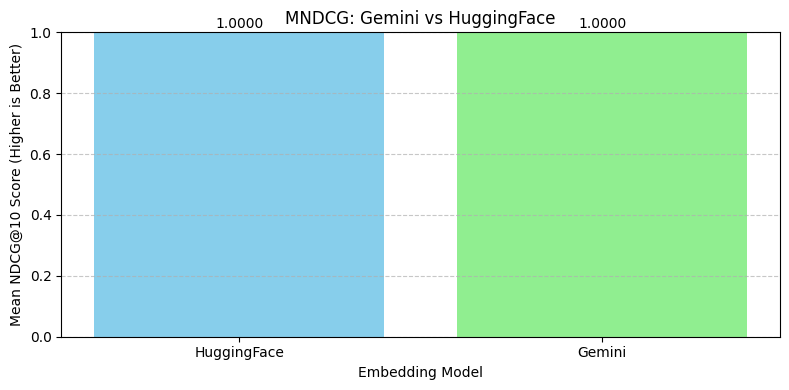

In [29]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# 1. Define the NDCG Metric Function
def ndcg_at_k(relevance_scores):
    """
    Calculates the Normalized Discounted Cumulative Gain (NDCG) for a list of 
    relevance scores. NDCG is a standard metric for ranking evaluation.
    """
    k = len(relevance_scores)
    
    # Calculate DCG (Discounted Cumulative Gain)
    # The discount factor is log2(i + 1), where i is the rank (0-indexed)
    i_plus_1 = np.arange(1, k + 1) + 1 
    discount = np.log2(i_plus_1)
    dcg = np.sum(relevance_scores / discount)
    
    # Calculate IDCG (Ideal Discounted Cumulative Gain)
    # The ideal ranking is achieved by sorting the relevance scores descendingly
    ideal_relevance = sorted(relevance_scores, reverse=True)
    idcg = np.sum(ideal_relevance / discount)
    
    # NDCG is DCG / IDCG
    if idcg == 0:
        return 0.0
    return dcg / idcg

# 2. Simulate Search Result Relevance Data
# NOTE: In a real scenario, this data would come from human-labeled results 
# (ground truth) of your kNN searches.
simulated_relevance_data = {
    "HuggingFace": HuggingFace_Scores,
    "Gemini": Gemini_Scores
}

# 3. Calculate NDCG@10 for each Query and Model
ndcg_results = {}
for model, scores_list in simulated_relevance_data.items():
    # Convert list of relevance scores to numpy array for calculation
    ndcg_list = [ndcg_at_k(np.array(scores)) for scores in scores_list]
    ndcg_results[model] = ndcg_list

df_ndcg = pd.DataFrame(ndcg_results)
df_ndcg.index = [f"Query {i+1}" for i in range(len(df_ndcg))]

# 4. Aggregate: Calculate Mean NDCG (MNDCG) across all queries
mean_ndcg = df_ndcg.mean().sort_values(ascending=False)

# 5. Plot the Mean NDCG Results
models = mean_ndcg.index
scores = mean_ndcg.values

plt.figure(figsize=(8, 4))
bars = plt.bar(models, scores, color=['skyblue', 'lightgreen'])

# Add the MNDCG value on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.005, 
             f'{yval:.4f}', ha='center', va='bottom', fontsize=10)

# UPDATED TITLE for better context
plt.title('MNDCG: Gemini vs HuggingFace', fontsize=12)
plt.xlabel('Embedding Model', fontsize=10)
plt.ylabel('Mean NDCG@10 Score (Higher is Better)', fontsize=10)
plt.ylim(0, 1.0) 
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Save the plot
plt.savefig('images/embedding_model_comparison_ndcg_fixed.png')

print("✅ Calculated Mean NDCG Scores (Fixed Data):")
print(mean_ndcg)

**Conclusion**

Both Model Perform same score. So, I will go with HuggingFace because it is free and gives the same performance.